### Understanding Code

### Main.py

In [3]:
import nonlinear_solver_initial as solver     #solves opt. problems for terminal VF
import nonlinear_solver_iterate as solviter   #solves opt. problems during VFI
from parameters import *                      #parameters of model
import interpolation as interpol              #interface to sparse grid library/terminal VF
import interpolation_iter as interpol_iter    #interface to sparse grid library/iteration
import postprocessing as post                 #computes the L2 and Linfinity error of the model

import TasmanianSG                            #sparse grid library
import numpy as np

### Parameters

In [4]:
#======================================================================
# 
#     sets the parameters for the model
#     "Growth Model"
#
#     The model is described in Scheidegger & Bilionis (2017)
#     https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2927400
#
#     Simon Scheidegger, 11/16 ; 07/17
#====================================================================== 

import numpy as np

#====================================================================== 

# Depth of "Classical" Sparse grid
iDepth=1
iOut=1         # how many outputs
which_basis = 1 #linear basis function (2: quadratic local basis)

# control of iterations
numstart = 0   # which is iteration to start (numstart = 0: start from scratch, number=/0: restart)
numits = 10    # which is the iteration to end

# How many random points for computing the errors
No_samples = 1000

#====================================================================== 

# Model Paramters

n_agents=2  # number of continuous dimensions of the model

beta=0.8
rho=0.95
zeta=0.5
psi=0.36
gamma=2.0
delta=0.025
eta=1
big_A=(1.0-beta)/(psi*beta)

# Ranges For States
range_cube=1 # range of [0..1]^d in 1D
k_bar=0.2
k_up=3.0

# Ranges for Controls
c_bar=1e-2
c_up=10000.0

l_bar=1e-2
l_up=1.0

inv_bar=1e-2
inv_up=10000.0

#====================================================================== 



In [7]:
#======================================================================
# Start with Value Function Iteration

# terminal value function
valnew=TasmanianSG.TasmanianSparseGrid()
if (numstart==0):
    ### Get sparse grid with n_agents state and iDepth
    valnew=interpol.sparse_grid(n_agents, iDepth)
    valnew.write("valnew_1." + str(numstart) + ".txt") #write file to disk for restart

# value function during iteration
else:
    valnew.read("valnew_1." + str(numstart) + ".txt")  #write file to disk for restart
    
valold=TasmanianSG.TasmanianSparseGrid()
valold=valnew

for numits in range(1, 10): 
for i in range(numstart, numits):
    valnew=TasmanianSG.TasmanianSparseGrid()
    valnew=interpol_iter.sparse_grid_iter(n_agents, iDepth, valold)
    valold=TasmanianSG.TasmanianSparseGrid()
    valold=valnew
    valnew.write("valnew_1." + str(i+1) + ".txt")
    
#======================================================================
print( "===============================================================")
print( " " )
print( " Computation of a growth model of dimension ", n_agents ," finished after ", numits, " steps")
print( " " )
print( "===============================================================")
#======================================================================

# compute errors   
avg_err=post.ls_error(n_agents, numstart, numits, No_samples)

#======================================================================
print( "===============================================================")
print( " ")
print( " Errors are computed -- see errors.txt")
print( " ")
print( "===============================================================")
#======================================================================

 
(' Computation of a growth model of dimension ', 2, ' finished after ', 10, ' steps')
 
 
 Errors are computed -- see errors.txt
 


### interpolation.py

In [4]:
#======================================================================
#
#     This routine interfaces with the TASMANIAN Sparse grid
#     The crucial part is 
#
#     aVals[iI]=solver.initial(aPoints[iI], n_agents)[0]  
#     => at every gridpoint, we solve an optimization problem
#
#     Simon Scheidegger, 11/16 ; 07/17
#======================================================================

import TasmanianSG
import numpy as np
from parameters import *
import nonlinear_solver_initial as solver

#======================================================================

def sparse_grid(n_agents, iDepth):
    
    grid  = TasmanianSG.TasmanianSparseGrid()

    k_range=np.array([k_bar, k_up])

    ranges=np.empty((n_agents, 2))


    for i in range(n_agents):
        ranges[i]=k_range

    iDim=n_agents

    grid.makeLocalPolynomialGrid(iDim, iOut, iDepth, which_basis, "localp")
    grid.setDomainTransform(ranges)

    aPoints=grid.getPoints()
    iNumP1=aPoints.shape[0]
    aVals=np.empty([iNumP1, 1])
    
    file=open("comparison0.txt", 'w')
    for iI in range(iNumP1):
        aVals[iI]=solver.initial(aPoints[iI], n_agents)[0] 
        v=aVals[iI]*np.ones((1,1))
        to_print=np.hstack((aPoints[iI].reshape(1,n_agents), v))
        np.savetxt(file, to_print, fmt='%2.16f')
        
    file.close()
    grid.loadNeededPoints(aVals)
    
    f=open("grid.txt", 'w')
    np.savetxt(f, aPoints, fmt='% 2.16f')
    f.close()
    
    return grid
#======================================================================

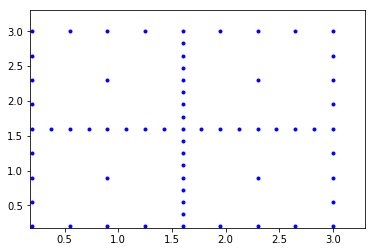

<module 'matplotlib.pyplot' from '/software/python-2.7.12-el7-x86_64/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [8]:
valnew=interpol.sparse_grid(2, 4)
valnew.plotPoints2D()

### nonlinear_solver_initial.py

In [ ]:
#======================================================================
#
#     This routine interfaces with IPOPT
#     It sets the optimization problem for every gridpoint
#     at the beginning of the VFI.
#
#     Simon Scheidegger, 11/16 ; 07/17
#======================================================================

from parameters import *
from ipopt_wrapper import EV_F, EV_GRAD_F, EV_G, EV_JAC_G
import numpy as np
import pyipopt

#======================================================================

def initial(k_init, n_agents):
    # IPOPT PARAMETERS below 
    nvars=3*n_agents
    N=nvars         # number of vars
    M=3*n_agents+1  # number of constraints
    NELE_JAC=N*M
    NELE_HESS=(N**2-N)/2 + N    # number of non-zero entries of Hess matrix

    # check that number of nonlinear equations is consistent 
    if (N!=3*n_agents):
        print("there is an error with the number of non-lin eqs!")
        quit

    # Vector of variables -> solution of non-linear equation system 
    X=np.empty(N)

    LAM=np.empty(M) # multipliers
    G=np.empty(M)   # (in-)equality constraints

    # Vector of lower and upper bounds
    G_L=np.empty(M)
    G_U=np.empty(M)

    X_L=np.empty(N)
    X_U=np.empty(N)

    Z_L=np.empty(N)
    Z_U=np.empty(N)

    # get coords of an individual grid points 
    grid_pt_box=k_init
    X_L[:n_agents]=c_bar
    X_U[:n_agents]=c_up

    X_L[n_agents:2*n_agents]=l_bar
    X_U[n_agents:2*n_agents]=l_up

    X_L[2*n_agents:3*n_agents]=inv_bar
    X_U[2*n_agents:3*n_agents]=inv_up

    # Set bounds for the constraints 
    G_L[:n_agents]=c_bar
    G_U[:n_agents]=c_up

    G_L[n_agents:2*n_agents]=l_bar
    G_U[n_agents:2*n_agents]=l_up

    G_L[2*n_agents:3*n_agents]=inv_bar
    G_U[2*n_agents:3*n_agents]=inv_up

    G_L[3*n_agents]=0.0 # both values set to 0 for equality contraints
    G_U[3*n_agents]=0.0

    # initial guesses for first iteration
    cons_init=0.5*(X_U[:n_agents] - X_L[:n_agents]) + X_L[:n_agents]
    lab_init=0.5*(X_U[n_agents:2*n_agents] - X_L[n_agents:2*n_agents]) + X_L[n_agents:2*n_agents]
    inv_init=0.5*(X_U[2*n_agents:3*n_agents] - X_L[2*n_agents:3*n_agents]) + X_L[2*n_agents:3*n_agents]

    X[:n_agents]=cons_init
    X[n_agents:2*n_agents]=lab_init
    X[2*n_agents:3*n_agents]=inv_init
    #X=np.ones(nvars)
    
    # Create ev_f, eval_f, eval_grad_f, eval_g, eval_jac_g for given k_init and n_agent 
    def eval_f(X):
        return EV_F(X, k_init, n_agents)
    
    def eval_grad_f(X):
        return EV_GRAD_F(X,k_init, n_agents)
    
    def eval_g(X):
        return EV_G(X, k_init, n_agents)
        
    def eval_jac_g(X, flag):
        return EV_JAC_G(X, flag, k_init, n_agents)
        
    # First create a handle for the Ipopt problem 
    nlp=pyipopt.create(nvars, X_L, X_U, M, G_L, G_U, NELE_JAC, NELE_HESS, eval_f, eval_grad_f, eval_g, eval_jac_g)
    nlp.num_option("obj_scaling_factor", -1.00)
    nlp.num_option("tol", 1e-6)
    nlp.num_option("acceptable_tol", 1e-5)
    nlp.str_option("derivative_test", "first-order")
    nlp.str_option("hessian_approximation", "limited-memory")
    nlp.int_option("print_level", 0)
    
    x, z_l, z_u, constraint_multipliers, obj, status=nlp.solve(X)
    nlp.close()
    # x: Solution of the primal variables
    # z_l, z_u: Solution of the bound multipliers
    # constraint_multipliers: Solution of the constraint multipliers
    # obj: Objective value
    # status: Exit Status

    # Unpack Consumption, Labor, and Investment 
    c=x[:n_agents]
    l=x[n_agents:2*n_agents]
    inv=x[2*n_agents:3*n_agents]
    
    to_print=np.hstack((obj,x))
    
    # == debug ==
    #f=open("results.txt", 'a')
    #np.savetxt(f, np.transpose(to_print) #, fmt=len(x)*'%10.10f ')
    #for num in to_print:
    #    f.write(str(num)+"\t")
    #f.write("\n")
    #f.close()
    
    return obj, c, l, inv

### interpolation_iter.py

In [ ]:
#======================================================================
#
#     This routine interfaces with the TASMANIAN Sparse grid
#     The crucial part is 
#
#     aVals[iI]=solveriter.iterate(aPoints[iI], n_agents)[0]  
#     => at every gridpoint, we solve an optimization problem
#
#     Simon Scheidegger, 11/16 ; 07/17
#======================================================================

import TasmanianSG
import numpy as np
from parameters import *
import nonlinear_solver_iterate as solveriter

#======================================================================

def sparse_grid_iter(n_agents, iDepth, valold):
    
    grid  = TasmanianSG.TasmanianSparseGrid()

    k_range=np.array([k_bar, k_up])

    ranges=np.empty((n_agents, 2))


    for i in range(n_agents):
        ranges[i]=k_range

    iDim=n_agents
    iOut=1

    grid.makeLocalPolynomialGrid(iDim, iOut, iDepth, which_basis, "localp")
    grid.setDomainTransform(ranges)

    aPoints=grid.getPoints()
    iNumP1=aPoints.shape[0]
    aVals=np.empty([iNumP1, 1])
    
    file=open("comparison1.txt", 'w')
    for iI in range(iNumP1):
        aVals[iI]=solveriter.iterate(aPoints[iI], n_agents, valold)[0]
        v=aVals[iI]*np.ones((1,1))
        to_print=np.hstack((aPoints[iI].reshape(1,n_agents), v))
        np.savetxt(file, to_print, fmt='%2.16f')
        
    file.close()
    grid.loadNeededPoints(aVals)
    
    f=open("grid_iter.txt", 'w')
    np.savetxt(f, aPoints, fmt='% 2.16f')
    f.close()
    
    return grid

#======================================================================